# Explore the Seattle Airbnb dataset<br>

### 1. Business Understanding

This notebook explores Seattle Airbnb listings and booking data. It aims at answering below business questions:
 - How are the listings on Seattle booked out over the time?
 - What are the listings distribution in terms of property type, price and booking rate?
 - How well can we predict listing price?

### 2. Data Understanding

Two datasets are explored that are originally provided by __[Kaggle](https://www.kaggle.com/code/moh3azzam/seattle-airbnb-data/data)__ project. The 3rd dataset from the project is listing reviews. The understanding of this dataset requires NLP knowledge which is out of the scope of this analysis.

#### 2.1 Data assessment (column meaning understand and distributions)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
warnings.filterwarnings("ignore")

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
listings = pd.read_csv('archive/listings.csv')
calendar = pd.read_csv('archive/calendar.csv')
print('listing shape: ',listings.shape)
print('calendar shape: ',calendar.shape)

listing shape:  (3818, 92)
calendar shape:  (1393570, 4)


In [5]:
#functions to output column stats and distribution visualizaions
def df_col_features(col_nm, col_val):
    col_f_dict = {}

    #col datatype
    col_f_dict['dtypes'] = col_val.dtypes

    #col null value cnt & pct
    col_f_dict['null_cnt'] = col_val.isnull().sum()
    col_f_dict['null_pct'] = col_val.isnull().mean()

    #if column with over 50% null, consider drop
    if col_f_dict['null_pct'] > 0.5:
        col_f_dict['null_large'] = 1
    else:
        col_f_dict['null_large'] = 0

    #col unique value counts
    col_f_dict['nunique'] = col_val.nunique()
    col_f_dict['freq_unique'] = len(col_val)/col_val.nunique() if col_val.nunique() !=0  else 0

    #if column with large number of unique values, consider drop
    if col_f_dict['freq_unique'] < 2:
        col_f_dict['nunique_large'] = 1
    else:
        col_f_dict['nunique_large'] = 0
    
    #col value top5 into list -- most common 5 vlaues
    col_f_dict['value_top5'] = col_val.value_counts().index.tolist()[:5]
  
    #col value count(into dataframe):
    col_f_dict['value_df'] = col_val.value_counts().rename_axis(col_nm).reset_index(name='frequency')

    #plot: object - barplot if nunique is not large; int/float - histogram
    if (col_f_dict['dtypes'] == 'object') and (col_f_dict['nunique_large'] == 0):
        col_f_dict['frequency_plot'] = 'barplot'
        col_f_dict['value_df'].set_index(col_nm).plot(kind='bar',figsize=(16,10),color='green',alpha=0.5)
        plt.xlabel(col_nm)
        plt.ylabel('frequency')
        plt.title(f'Column value distribution: {col_nm}')
        plt.savefig(f'frequency_plot/{col_nm}_barplot.jpg',bbox_inches='tight',dpi=300)
        plt.close()
    
    elif col_f_dict['dtypes'] in ['int','float']:
        col_f_dict['frequency_plot'] = 'histogram'
        col_val.hist(bins=10,figsize=(16,10),color='orange',alpha=0.5)
        plt.xlabel(col_nm)
        plt.ylabel('frequency')
        plt.title(f'Column value distribution: {col_nm}')
        plt.savefig(f'frequency_plot/{col_nm}_histplot.jpg',bbox_inches='tight',dpi=300)
        plt.close()
    
    else:
        col_f_dict['frequency_plot'] = 'no graph'
    
    return col_f_dict

def loop_col(df):
    all_col_dict = {}
    all_col_list = []
    col_nm_list = df.columns
    for col in col_nm_list:
        col_f_dict = df_col_features(col,df[col])
        all_col_dict[col] = col_f_dict
        col_f_list = [col_f_dict['dtypes'],col_f_dict['null_cnt'],col_f_dict['null_pct'],col_f_dict['null_large'],col_f_dict['nunique'],col_f_dict['freq_unique'],
                    col_f_dict['nunique_large'],col_f_dict['value_top5'],col_f_dict['frequency_plot']]
        all_col_list.append(col_f_list)
    features = ['dtype','null_cnt','null_pct','null_large','nunique','freq_unique','nunique_large','value_top5','frequency_plot']
    return col_nm_list, all_col_list, all_col_dict, features

In [9]:
#Outputs are stats about all columns of both datasets. 
#They are used to determine the cleaning work required for the columns of interests in analytics and price predictions
listing_col_nm_list, listing_col_f_list, listing_col_f_dict, features = loop_col(listings)
listing_col_review = pd.DataFrame(listing_col_f_list,columns=features).set_index(listing_col_nm_list)
listing_col_review.to_csv('listings_col_before_clean.csv')
calendar_col_nm_list, calendar_col_f_list, calendar_col_f_dict, features = loop_col(calendar)
calendar_col_review = pd.DataFrame(calendar_col_f_list,columns=features).set_index(calendar_col_nm_list)
calendar_col_review.to_csv('calendar_col_before_clean.csv')

#### 2.2 Booking trends

In [8]:
#calendar data clean - add date details and convert data type of price column
calendar['date_dt'] = pd.to_datetime(calendar['date'])
calendar['date_month'] = calendar['date_dt'].dt.month
calendar['date_year'] = calendar['date_dt'].dt.year
calendar['date_quarter'] = calendar['date_dt'].dt.quarter
calendar['date_weekday'] = calendar['date_dt'].dt.weekday
calendar['date_diff_last_scraped'] = (calendar['date_dt'] - datetime.strptime('2016-01-04','%Y-%m-%d')).dt.days #days diff integer
calendar['price'].fillna('$0.00',inplace=True)
calendar['price'] = calendar['price'].str.replace('$','')
calendar['price'] = calendar['price'].str.replace(',','')
calendar['price'].astype(float)
calendar.head()

,listing_id,date,available,price,date_dt,date_month,date_year,date_quarter,date_weekday,date_diff_last_scraped
0,241032,2016-01-04,t,85.00,2016-01-04,1,2016,1,0,0
1,241032,2016-01-05,t,85.00,2016-01-05,1,2016,1,1,1
2,241032,2016-01-06,f,0.00,2016-01-06,1,2016,1,2,2
3,241032,2016-01-07,f,0.00,2016-01-07,1,2016,1,3,3
4,241032,2016-01-08,f,0.00,2016-01-08,1,2016,1,4,4


#### booking overtime

We could estimate about 50% people book their trip within 30days ahead.<br>
Spikes of book are April, July and Christmas/New Year.

Text(0.5, 1.0, 'Listings availability overtime from last scraped date - 20160104')

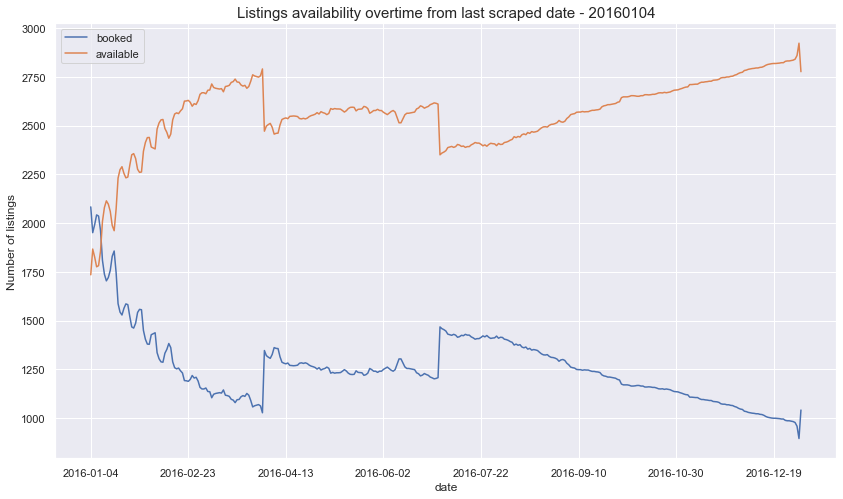

In [21]:
booking_day_pivot = calendar.pivot_table(index=['date'],columns=['available'],
                    values='listing_id', aggfunc='count')
booking_day_pivot.plot(figsize=(14,8))
plt.legend(['booked','available'])
plt.ylabel('Number of listings')
plt.title('Listings availability overtime from last scraped date - 20160104',fontdict = {'fontsize' : 15})

#### booking over the week

Weekdends (Thu through Sat) are more popular than weekdays.<br>
When people book over months ahead, there is not much difference among weekdays, people book at last minutes usually are planning for their weekend getaways.

Text(0.5, 1.0, 'listing booke rate over the week (week start from Monday)')

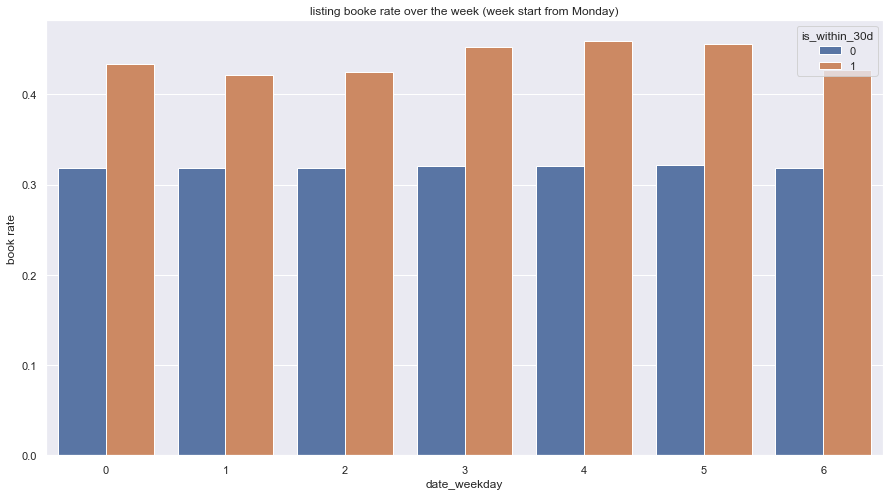

In [376]:
#booking by weekdays
calendar['is_within_30d'] = np.where(calendar['date_diff_last_scraped']<= 30,1,0)
bookings_weekday = calendar[calendar['available']=='f'].\
                groupby(['date_weekday','is_within_30d'])['listing_id'].count().reset_index(name='listing_cnt')
listings_weekday = calendar.groupby(['date_weekday','is_within_30d'])['listing_id'].count().reset_index(name='tota_listing_cnt')
book_rt_weekday = pd.merge(bookings_weekday,listings_weekday,how='left')
book_rt_weekday['book_rt'] = book_rt_weekday['listing_cnt']/book_rt_weekday['tota_listing_cnt']
sns.set(rc = {'figure.figsize':(15,8)})
sns.barplot(data=book_rt_weekday,x='date_weekday',y='book_rt',hue='is_within_30d')
plt.ylabel('book rate')
plt.title('listing booke rate over the week (week start from Monday)')

#### listing book rate

Looking at listing book rates, within next 30 days, about 30% properties are fully booked; while looking beyond 30days, there are still about 20% properties already booked over 80% of dates, at the same time about 25% have book rate below 10%. It will be interesting to dive more into what are the properties popular from way ahead of time and what makes them stand out. 

Text(0, 0.5, 'number of listings')

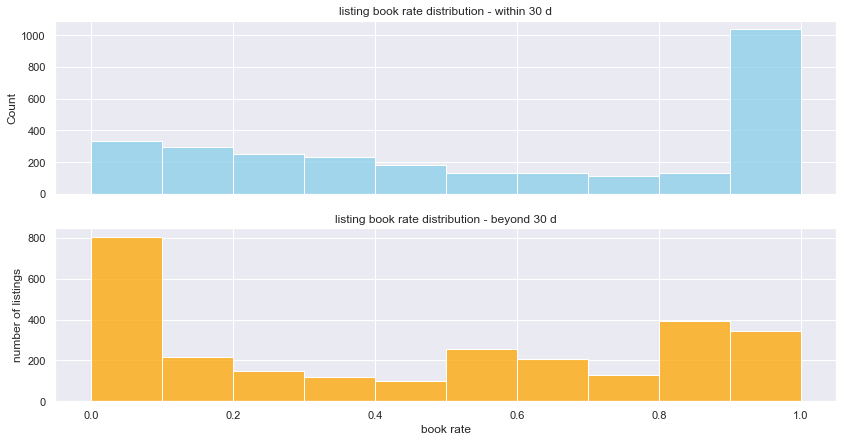

In [378]:
#listing booking rate distribution
listing_book = calendar[calendar['available']=='f'].\
                groupby(['listing_id','is_within_30d'])['date'].count().reset_index(name='book_dt_cnt')
listing_scrape = calendar.groupby(['listing_id','is_within_30d'])['date'].count().reset_index(name='scrape_dt_cnt')
listing_book_rt = pd.merge(listing_book, listing_scrape, how='left')
listing_book_rt['book_rt'] = listing_book_rt['book_dt_cnt']/listing_book_rt['scrape_dt_cnt']
fig,axs = plt.subplots(2,1,figsize=(14,7),sharex=True)
ax1 = axs[0]
ax2 = axs[1]
sns.histplot(data=listing_book_rt[listing_book_rt['is_within_30d']==1],x='book_rt',label='within 30d',color='skyblue',\
                                ax=ax1,bins=np.linspace(0, 1,num=11))
sns.histplot(data=listing_book_rt[listing_book_rt['is_within_30d']==0],x='book_rt',label='beyond 30d',color='orange',\
                                ax=ax2,bins=np.linspace(0,1,num=11))
ax1.title.set_text('listing book rate distribution - within 30 d')
ax2.title.set_text('listing book rate distribution - beyond 30 d')
plt.xlabel('book rate')
plt.ylabel('number of listings')



Text(0.5, 1.0, 'Listing booking rate migration from within 30 days to beyond 30 days within 1 year')

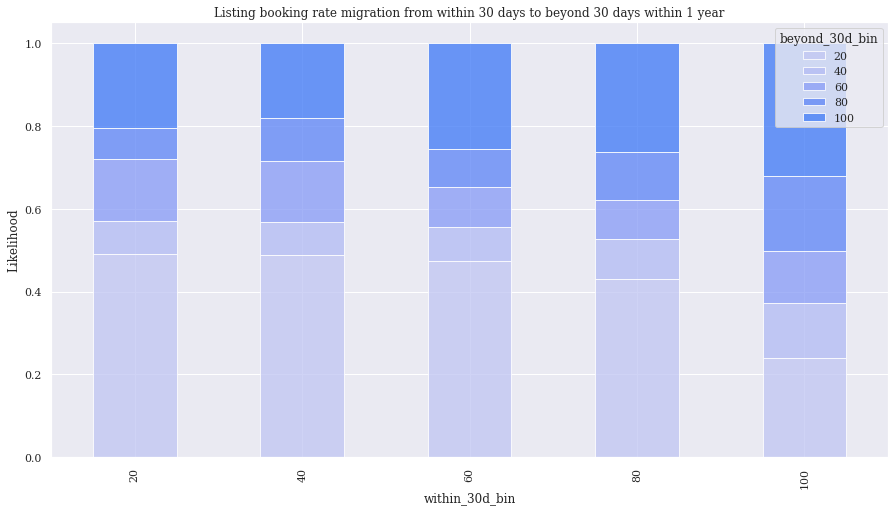

In [469]:
#listing booking rrate migration - weak correlation
bins = np.linspace(0, 1,num=6)
labels = [20,40,60,80,100]
colors = ['#c3c8f3','#b5bdf4','#8da0f6','#648af7','#477ff7']
listing_book_rt['book_rt_tier'] = pd.cut(listing_book_rt['book_rt'],bins=bins, labels=labels, include_lowest=True)
listing_book_rt_pivot = listing_book_rt.pivot_table(index='listing_id',columns='is_within_30d',values='book_rt_tier',aggfunc='first').reset_index()
listing_book_rt_pivot.columns = ['listing_id','beyond_30d_bin','within_30d_bin']
listing_book_rt_cross = pd.crosstab(listing_book_rt_pivot['within_30d_bin'],listing_book_rt_pivot['beyond_30d_bin'],\
                                    values=listing_book_rt_pivot['listing_id'],aggfunc='count',normalize='index')
sns.color_palette("Blues", as_cmap=True)
listing_book_rt_cross.plot(kind='bar',stacked=True,alpha=0.8,color=colors)
plt.ylabel('Likelihood')
plt.title('Listing booking rate migration from within 30 days to beyond 30 days within 1 year')

#### 2.3 Listing trends

#### cleaning listing data for analytics/prediction

* drop rows with below any of below columns as null; these columns are with little amount of null, and wouldn't want to fillna

In [24]:
null_drop_cols_any = ['host_name','host_since','host_location','host_is_superhost','host_thumbnail_url',\
                    'host_picture_url','host_listings_count','host_total_listings_count','host_has_profile_pic',\
                    'host_identity_verified','zipcode','property_type','bathrooms','bedrooms','beds']
listings.drop(listings[listings[null_drop_cols_any].isnull().any(axis=1)].index, inplace=True)
listings.shape #38 rows were dropped

(3780, 92)

* columns need manually work on value update/clean

In [25]:
#listing out columns for tracking
col_calc_manual = ['host_neighbourhood','host_verifications','neighbourhood','calendar_updated','property_type','host_response_time']
#compute whether host and listing are from same neighborhood; original two columns could be dropped afterwards
listings['host_listing_same_neighbor'] = np.where(listings['host_neighbourhood']==listings['neighbourhood'],1,0)

#host verification - to list, convert column to (1)len; (2)whether contain most common; original column could be dropped afterward
listings['host_verifications'] = listings['host_verifications'].map(lambda x: x.strip("[]").replace("'",'').split(', '))
listings['host_verifications_cnt'] = listings['host_verifications'].map(lambda a:len(a))
def issubset_list(set_list):
    if set(set_list).issubset(set(['email','phone','reviews'])):
        return 1
    else:
        return 0
listings['host_verifications_basic'] = listings['host_verifications'].map(issubset_list)

#calendar_updated manually map to new values;
def replace_dt_unit(col):
    if 'today' in col:
        return '0 day ago'
    elif 'yesterday' in col:
        return '1 day ago'
    elif 'never' in col:
        return '500 days ago'
    elif 'a week ago' in col:
        return '1 week ago'
    else:
        return col
def extract_dt_unit(col_string):
    if 'day' in col_string:
        return 1
    elif 'week' in col_string:
        return 7
    elif 'month' in col_string:
        return 30
    else:
        return 999

listings['calendar_updated'] = listings['calendar_updated'].map(replace_dt_unit)
listings['calendar_updated_dttype'] = listings['calendar_updated'].map(extract_dt_unit)
listings['calendar_dt_num'] = listings['calendar_updated'].map(lambda x:int(x.split()[0]))
listings['calendar_updated'] = listings['calendar_updated_dttype']*listings['calendar_dt_num']
del listings['calendar_updated_dttype']
del listings['calendar_dt_num']

#further group property type
def replace_group(col):
    if 'House' == col:
        return 'House'
    elif 'Apartment' == col:
        return 'Apartment'
    else:
        return 'Other'
listings['property_type'] = listings['property_type'].map(replace_group)

#convert response time to integer/number
def replace_resp_val(col):
    if col == 'within an hour':
        return 1
    elif col == 'within a few hours':
        return 2
    elif col == 'within a day':
        return 3
    elif col == 'a few days or more':
        return 4
    else:
        return 5
listings['host_response_time'] = listings['host_response_time'].map(replace_resp_val)

* columns to add new column for whether null values

In [26]:
col_add_ifnull = ['summary','space','neighborhood_overview','notes','transit','thumbnail_url','host_about','first_review']
def col_add_new_ifnull(col):
    return np.where(listings[col].isnull(),0,1)
for col in col_add_ifnull:
    new_col = col+'_ifnull'
    listings[new_col] = col_add_new_ifnull(col)

* columns to date and calculate datediff

In [27]:
col_to_dt = ['last_scraped','host_since','first_review','last_review']
for col in col_to_dt:
    listings[col] = pd.to_datetime(listings[col])
col_calc_dt_diff = ['host_since','first_review','last_review']
for col in col_calc_dt_diff:
    listings[col] = (listings['last_scraped'] - listings[col]).dt.days #days diff integer

* columns to fillna with specific values

In [28]:
col_fillna = {'host_response_rate':'0%','weekly_price':'$10000.00', 'monthly_price':'$100000.00',\
            'security_deposit':'$0.00','cleaning_fee':'$0.00','review_scores_rating':0,'review_scores_accuracy':0,\
            'review_scores_cleanliness':0,'review_scores_checkin':0, 'review_scores_communication':0, 'review_scores_location':0,\
            'review_scores_value':0,'reviews_per_month':0,'first_review':4000,'last_review':4000}
for key,value in col_fillna.items():
    listings[key].fillna(value,inplace=True)

* columns with string replacement update

In [29]:
col_clean_str = {'host_response_rate':['%'], 'price':['$',','], 'weekly_price':['$',','], 'monthly_price':['$',','], \
                'security_deposit':['$',','],'cleaning_fee':['$',','], 'extra_people':['$',',']}
for key,value in col_clean_str.items():
    for i in value:
        listings[key] = listings[key].str.replace(i,'')

* columns with dtype update

In [30]:
col_to_float = ['host_response_rate','price','weekly_price','monthly_price','security_deposit','cleaning_fee','extra_people']
for col in col_to_float:
    listings[col] = listings[col].astype(float)

* columns with map value based on dict

In [31]:
col_to_int = {'host_is_superhost':{'t':1,'f':0},'host_identity_verified':{'t':1,'f':0},\
            'is_location_exact':{'t':1,'f':0},'instant_bookable':{'t':1,'f':0}, 'cancellation_policy':{'strict':1,'moderate':2,'flexible':3},\
            'require_guest_profile_picture':{'t':1,'f':0}, 'require_guest_phone_verification':{'t':1,'f':0}}
for key,value in col_to_int.items():
    listings[key] = listings[key].map(value)

* coumns to drop (not include analytics and predictions)

In [32]:
col_drop_analy = ['listing_url','scrape_id','last_scraped','name','summary','space','description','experiences_offered',\
                'neighborhood_overview','notes','transit','thumbnail_url','medium_url','picture_url','xl_picture_url','host_id',\
                'host_url','host_name','host_location','host_about','host_acceptance_rate','host_thumbnail_url','host_picture_url',\
                'host_neighbourhood','host_verifications','host_has_profile_pic','street','neighbourhood','neighbourhood_cleansed',\
                'city','state','zipcode','market','smart_location','country_code','country','latitude','longitude','bed_type', \
                'amenities', 'square_feet','has_availability','calendar_last_scraped','requires_license','license','jurisdiction_names']
listings.drop(col_drop_analy,axis=1,inplace=True)


* run column review after clean

In [734]:
listing_col_nm_list, listing_col_f_list, listing_col_f_dict, features = loop_col(listings)
listing_col_review = pd.DataFrame(listing_col_f_list,columns=features).set_index(listing_col_nm_list)
listing_col_review.to_csv('listings_col_after_clean.csv')

* add listing booking information from calendar data

In [33]:
#merge listing book information from calendar data -- for listing curious about popularity by number of listing, and book rate
listings_add_booking = pd.merge(listings,listing_book_rt[listing_book_rt['is_within_30d']==1][['listing_id','book_rt']],\
                                left_on = 'id',right_on='listing_id',how='left')
listings_add_booking['book_rt'].fillna(0,inplace=True)
listings_add_booking.rename({'book_rt':'book_rt_30d'},axis = 1, inplace=True)
del listings_add_booking['listing_id']
listings_add_booking = pd.merge(listings_add_booking,listing_book_rt[listing_book_rt['is_within_30d']==0][['listing_id','book_rt']],\
                                left_on = 'id',right_on='listing_id',how='left')
listings_add_booking['book_rt'].fillna(0,inplace=True)
listings_add_booking.rename({'book_rt':'book_rt_1y'},axis=1,inplace=True)
del listings_add_booking['listing_id']          
listings_add_booking.head()   

,id,host_since,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_identity_verified,neighbourhood_group_cleansed,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,host_listing_same_neighbor,host_verifications_cnt,host_verifications_basic,summary_ifnull,space_ifnull,neighborhood_overview_ifnull,notes_ifnull,transit_ifnull,thumbnail_url_ifnull,host_about_ifnull,first_review_ifnull,book_rt_30d,book_rt_1y
0,241032,1607,2,96.0,0,3.0,3.0,1,Queen Anne,1,Apartment,Entire home/apt,4,1.0,1.0,1.0,85.0,10000.0,100000.0,0.0,0.0,2,5.0,1,365,28,14,41,71,346,207,1525.0,2.0,95.0,10.0,10.0,10.0,10.0,9.0,10.0,0,2,0,0,2,4.07,1,4,0,0,1,0,0,0,0,1,1,0.516129,0.008982
1,953595,1047,1,98.0,1,6.0,6.0,1,Queen Anne,1,Apartment,Entire home/apt,4,1.0,1.0,1.0,150.0,1000.0,3000.0,100.0,40.0,1,0.0,2,90,0,13,13,16,291,43,868.0,6.0,96.0,10.0,10.0,10.0,10.0,10.0,10.0,0,1,1,1,6,1.48,1,6,0,1,1,1,1,1,1,1,1,0.580645,0.167665
2,3308979,571,2,67.0,0,2.0,2.0,1,Queen Anne,1,House,Entire home/apt,11,4.5,5.0,7.0,975.0,10000.0,100000.0,1000.0,300.0,10,25.0,4,30,35,1,6,17,220,20,523.0,123.0,97.0,10.0,10.0,10.0,10.0,10.0,10.0,0,1,0,0,2,1.15,1,5,0,1,1,1,1,1,0,1,1,0.967742,0.344311
3,7421966,789,5,0.0,0,1.0,1.0,1,Queen Anne,1,Apartment,Entire home/apt,3,1.0,0.0,2.0,100.0,650.0,2300.0,0.0,0.0,1,0.0,1,1125,180,0,0,0,143,0,4000.0,4000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3,0,0,1,0.00,1,5,0,1,0,0,0,0,0,0,0,1.000000,0.571856
4,278830,1497,1,100.0,0,2.0,2.0,1,Queen Anne,1,House,Entire home/apt,6,2.0,3.0,3.0,450.0,10000.0,100000.0,700.0,125.0,6,15.0,1,1125,49,30,60,90,365,38,1273.0,72.0,92.0,9.0,9.0,10.0,10.0,9.0,9.0,0,1,0,0,1,0.89,1,5,0,1,1,1,1,1,0,1,1,0.000000,0.000000


#### listing trend by locations

In [39]:
#listings locations vs listing number/popularity
list_group_neigh = listings_add_booking.groupby('neighbourhood_group_cleansed').\
                agg({'id':'count','book_rt_30d':'mean','book_rt_1y':'mean','price':np.mean}).reset_index()
list_group_neigh.head()

,neighbourhood_group_cleansed,id,book_rt_30d,book_rt_1y,price
0,Ballard,228,0.473401,0.288147,124.570175
1,Beacon Hill,117,0.404191,0.289805,94.837607
2,Capitol Hill,558,0.467395,0.352853,130.329749
3,Cascade,89,0.556723,0.411492,140.101124
4,Central Area,367,0.473675,0.315791,128.683924


In [40]:
plt.rcParams["font.family"] = "sans-serif"

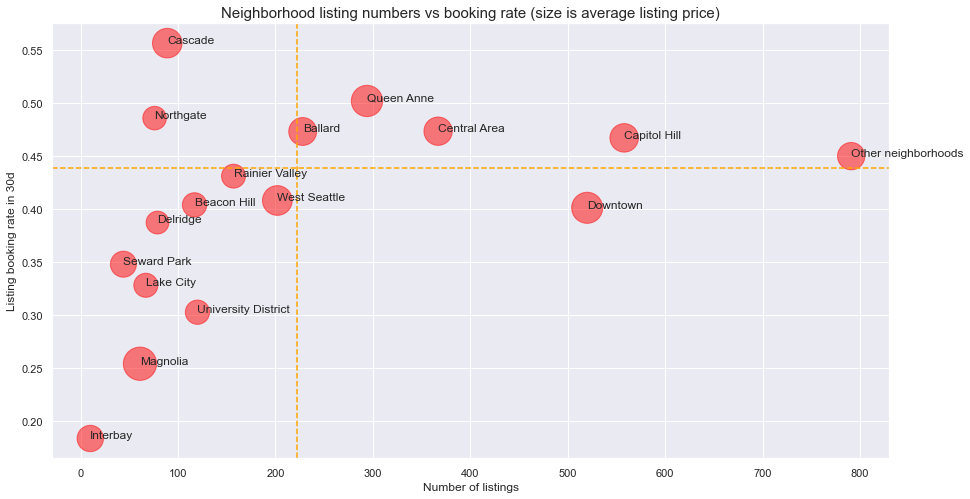

In [53]:
id_cnt = list_group_neigh['id']
book_rt1 = list_group_neigh['book_rt_30d']

neigh_nm = list_group_neigh['neighbourhood_group_cleansed']
plt.scatter(list_group_neigh['id'],list_group_neigh['book_rt_30d'],color='red',marker='.',s=list_group_neigh['price']*25,alpha=0.5)

for i, text in enumerate(neigh_nm):
    plt.text(id_cnt[i],book_rt1[i],text)

sns.set(rc = {'figure.figsize':(15,8)})
plt.xlabel('Number of listings')
plt.ylabel('Listing booking rate in 30d')
plt.title('Neighborhood listing numbers vs booking rate (size is average listing price)',fontdict = {'fontsize' : 15})
plt.axhline(y=listings_add_booking['book_rt_30d'].mean(), color='orange', linestyle='--')
plt.axvline(x=list_group_neigh['id'].mean(), color='orange', linestyle='--')

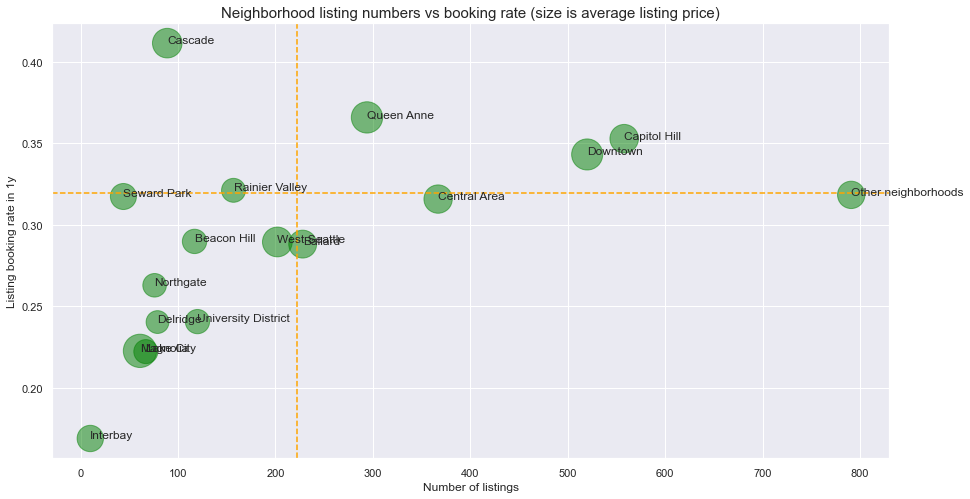

In [47]:
id_cnt = list_group_neigh['id']
book_rt = list_group_neigh['book_rt_1y']
neigh_nm = list_group_neigh['neighbourhood_group_cleansed']
plt.scatter(list_group_neigh['id'],list_group_neigh['book_rt_1y'],color='green',marker='.',s=list_group_neigh['price']*25,alpha=0.5)
for i, text in enumerate(neigh_nm):
    plt.text(id_cnt[i],book_rt[i],text)
plt.xlabel('Number of listings')
plt.ylabel('Listing booking rate in 1y')
plt.title('Neighborhood listing numbers vs booking rate (size is average listing price)',fontdict = {'fontsize' : 15})
plt.axhline(y=listings_add_booking['book_rt_1y'].mean(), color='orange', linestyle='--')
plt.axvline(x=list_group_neigh['id'].mean(), color='orange', linestyle='--')

Text(0.5, 1.0, 'Neighborhood listing numbers vs average listing price')

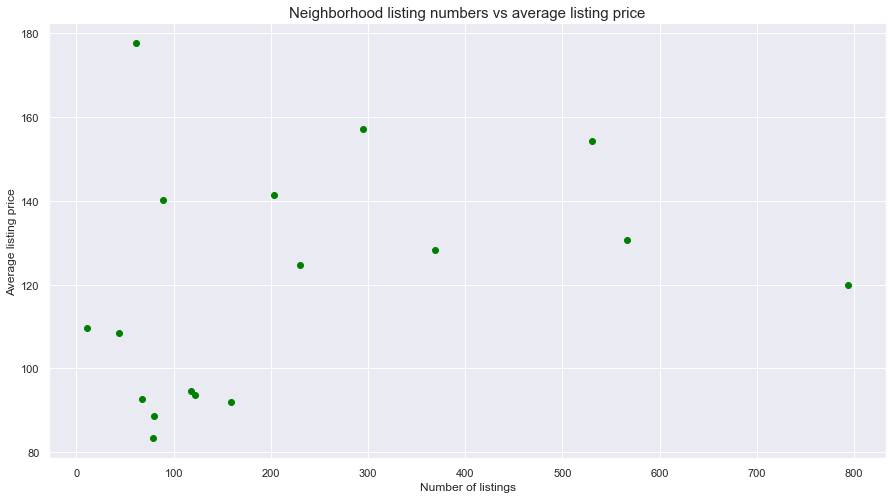

In [890]:
plt.scatter(list_group_neigh['id'],list_group_neigh['price'],color='green',marker='o')
plt.xlabel('Number of listings')
plt.ylabel('Average listing price')
plt.title('Neighborhood listing numbers vs average listing price',fontdict = {'fontsize' : 15})

#### listings trend by property type

In [891]:
#listings locations vs listing number/popularity
list_gp = listings_add_booking.groupby('room_type').\
                agg({'id':'count','book_rt_30d':'mean','book_rt_1y':'mean','price':np.mean}).reset_index()
list_gp.head()

,room_type,id,book_rt_30d,book_rt_1y,price
0,Entire home/apt,2514,0.482524,0.348796,156.100636
1,Private room,1149,0.361408,0.269857,74.714534
2,Shared room,117,0.276261,0.177619,47.547009


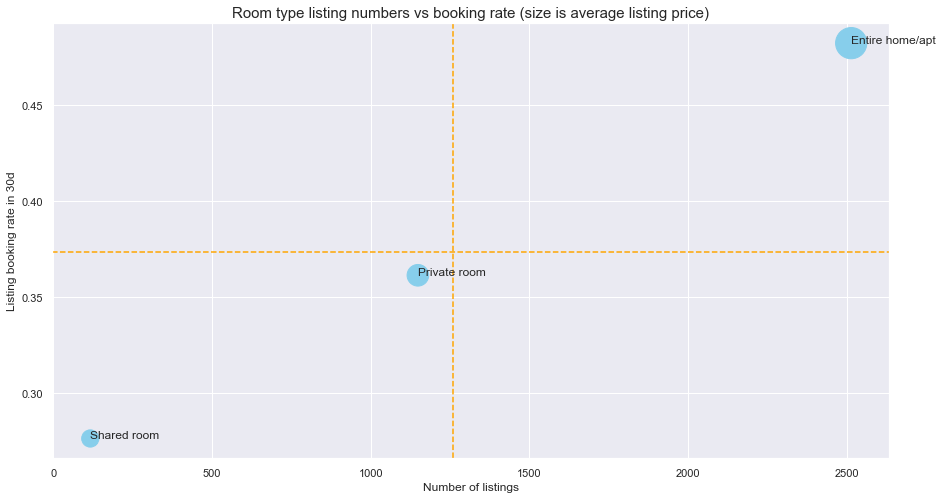

In [892]:
id_cnt = list_gp['id']
book_rt = list_gp['book_rt_30d']
nm = list_gp['room_type']
plt.scatter(list_gp['id'],list_gp['book_rt_30d'],color='skyblue',marker='.',s=list_gp['price']*25)
for i, text in enumerate(nm):
    plt.text(id_cnt[i],book_rt[i],text)
plt.xlabel('Number of listings')
plt.ylabel('Listing booking rate in 30d')
plt.title('Room type listing numbers vs booking rate (size is average listing price)',fontdict = {'fontsize' : 15})
plt.axhline(y=list_gp['book_rt_30d'].mean(), color='orange', linestyle='--')
plt.axvline(x=list_gp['id'].mean(), color='orange', linestyle='--')

Text(0.5, 1.0, 'Relationship of book rate (30d) and listing location exact')

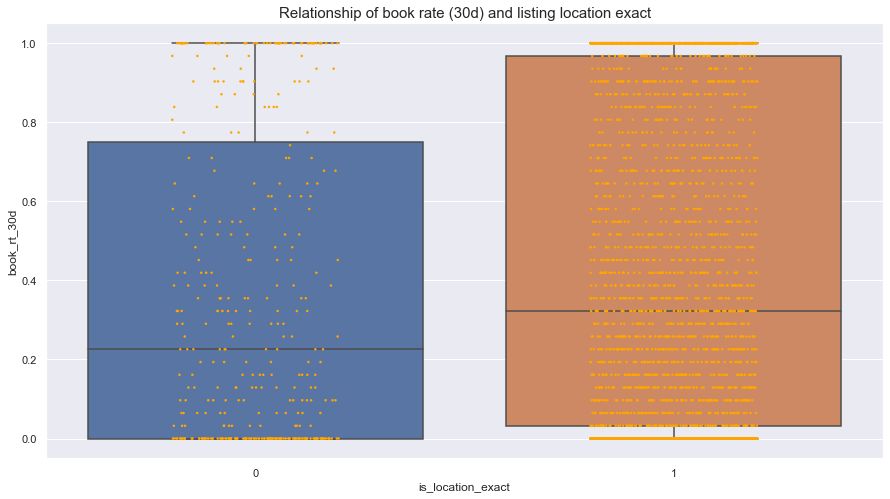

In [54]:
sns.boxplot(x=listings_add_booking["is_location_exact"], y=listings_add_booking["book_rt_30d"] )
sns.stripplot(x=listings_add_booking["is_location_exact"], y=listings_add_booking["book_rt_30d"], color="orange", jitter=0.2, size=2.5)
plt.title('Relationship of book rate (30d) and listing location exact',fontdict = {'fontsize' : 15})

Text(0.5, 1.0, 'Relationship of book rate (30d) and number of accomdates listings have')

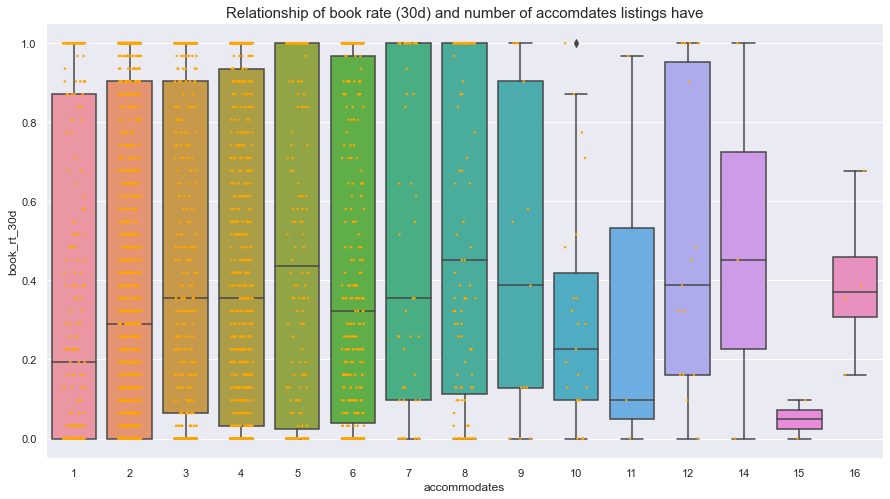

In [55]:
sns.boxplot(x=listings_add_booking["accommodates"], y=listings_add_booking["book_rt_30d"] )
sns.stripplot(x=listings_add_booking["accommodates"], y=listings_add_booking["book_rt_30d"], color="orange", jitter=0.2, size=2.5)
plt.title('Relationship of book rate (30d) and number of accomdates listings have',fontdict = {'fontsize' : 15})

Text(0.5, 1.0, 'Relationship of listing price and number of accomdates listings have')

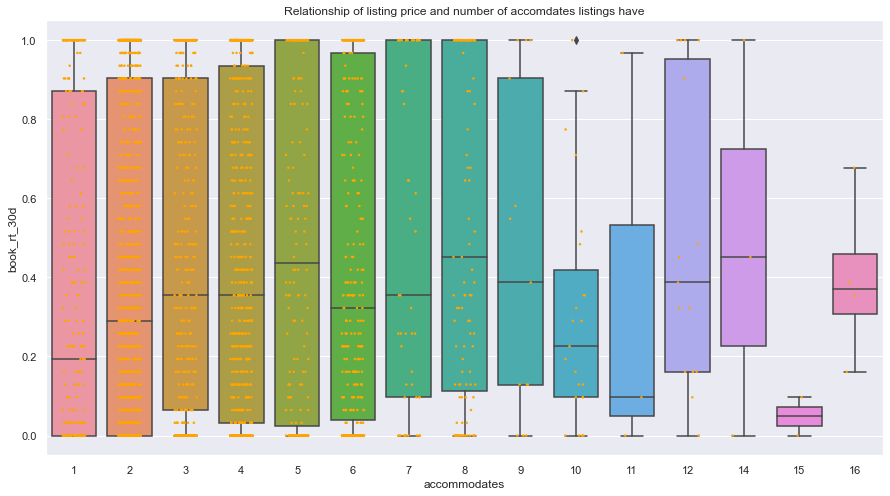

In [895]:
sns.boxplot(x=listings_add_booking["accommodates"], y=listings_add_booking["book_rt_30d"] )
sns.stripplot(x=listings_add_booking["accommodates"], y=listings_add_booking["book_rt_30d"], color="orange", jitter=0.2, size=2.5)
plt.title('Relationship of listing price and number of accomdates listings have')

Text(0.5, 1.0, 'Relationship of book rate (30d) and number of bathrooms')

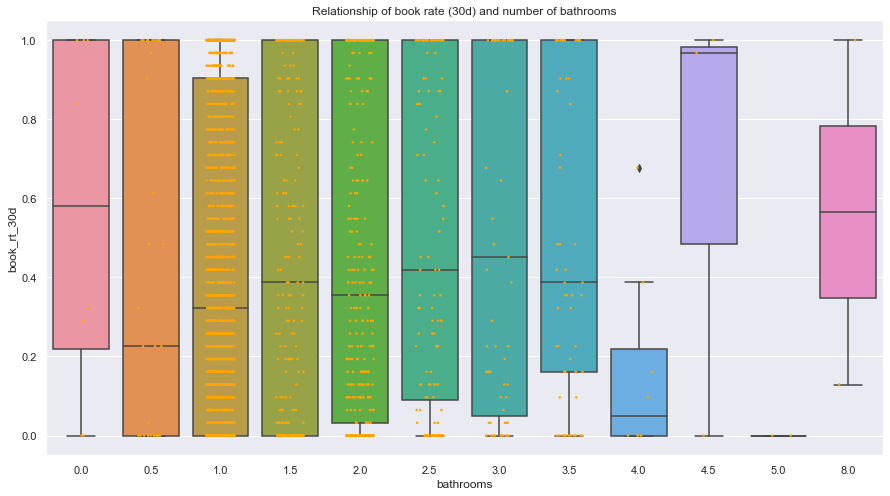

In [896]:
sns.boxplot(x=listings_add_booking["bathrooms"], y=listings_add_booking["book_rt_30d"] )
sns.stripplot(x=listings_add_booking["bathrooms"], y=listings_add_booking["book_rt_30d"], color="orange", jitter=0.2, size=2.5)
plt.title('Relationship of book rate (30d) and number of bathrooms')

Text(0.5, 1.0, 'Relationship of price and number of bathrooms')

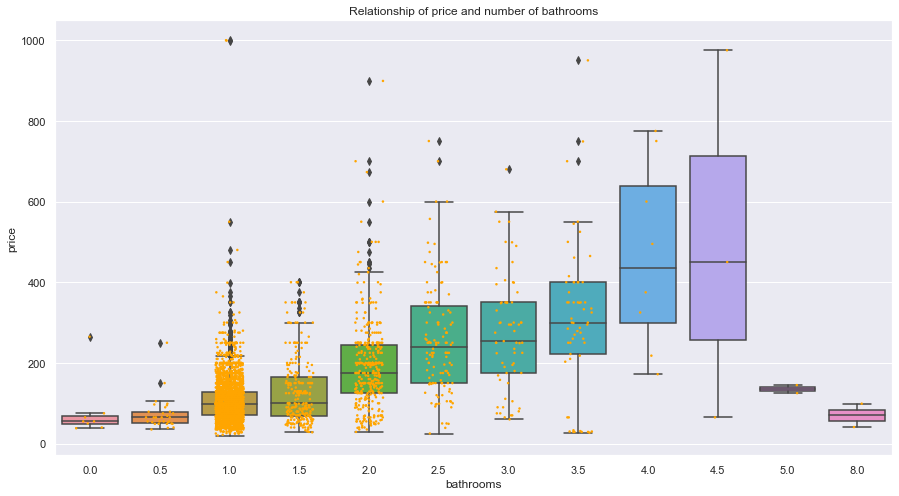

In [897]:
sns.boxplot(x=listings_add_booking["bathrooms"], y=listings_add_booking["price"] )
sns.stripplot(x=listings_add_booking["bathrooms"], y=listings_add_booking["price"], color="orange", jitter=0.2, size=2.5)
plt.title('Relationship of price and number of bathrooms')

Text(0.5, 1.0, 'Relationship of book rate (30d) and number of bedrooms')

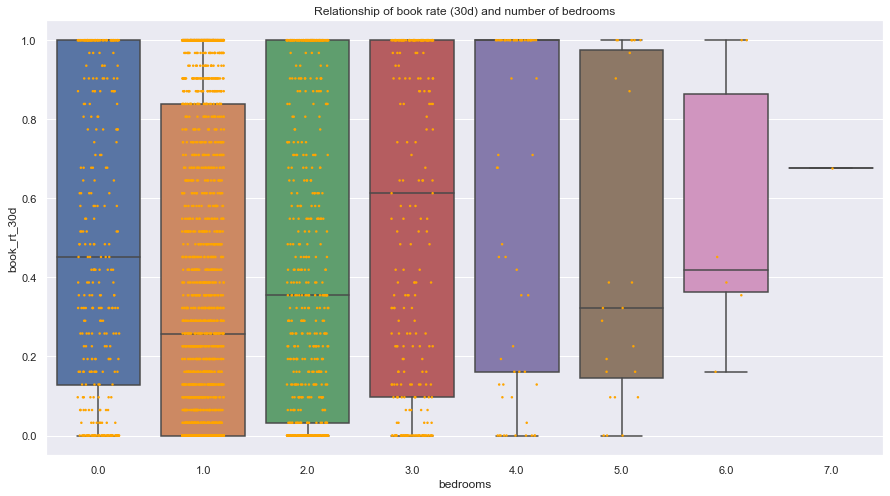

In [898]:
sns.boxplot(x=listings_add_booking["bedrooms"], y=listings_add_booking["book_rt_30d"] )
sns.stripplot(x=listings_add_booking["bedrooms"], y=listings_add_booking["book_rt_30d"], color="orange", jitter=0.2, size=2.5)
plt.title('Relationship of book rate (30d) and number of bedrooms')

Text(0.5, 1.0, 'Relationship of price and listing location exact')

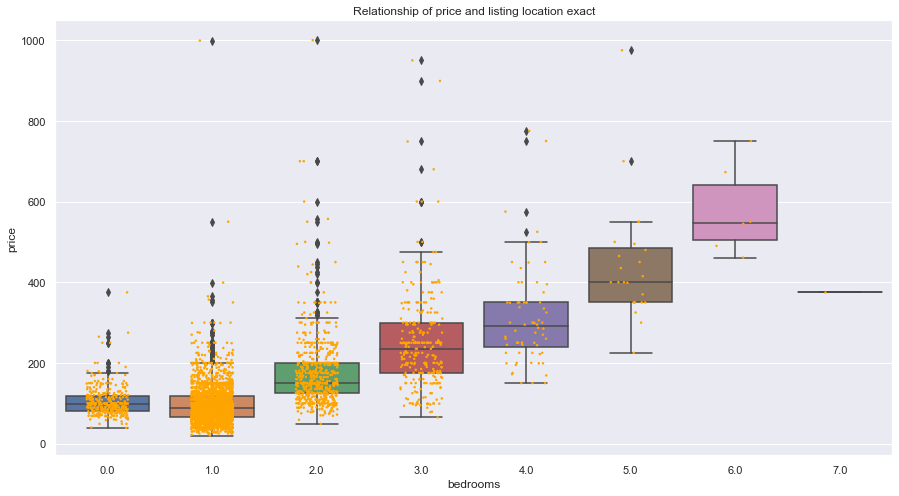

In [899]:
sns.boxplot(x=listings_add_booking["bedrooms"], y=listings_add_booking["price"] )
sns.stripplot(x=listings_add_booking["bedrooms"], y=listings_add_booking["price"], color="orange", jitter=0.2, size=2.5)
plt.title('Relationship of price and listing location exact')

Text(0.5, 1.0, 'Relationship of book rate (30d) and number of guests')

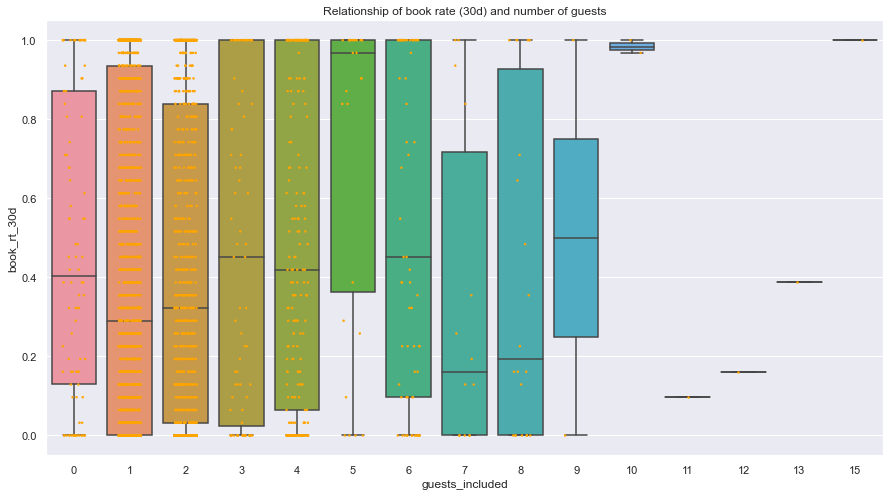

In [900]:
sns.boxplot(x=listings_add_booking["guests_included"], y=listings_add_booking["book_rt_30d"] )
sns.stripplot(x=listings_add_booking["guests_included"], y=listings_add_booking["book_rt_30d"], color="orange", jitter=0.2, size=2.5)
plt.title('Relationship of book rate (30d) and number of guests')

Text(0.5, 1.0, 'Relationship of price and number of guests')

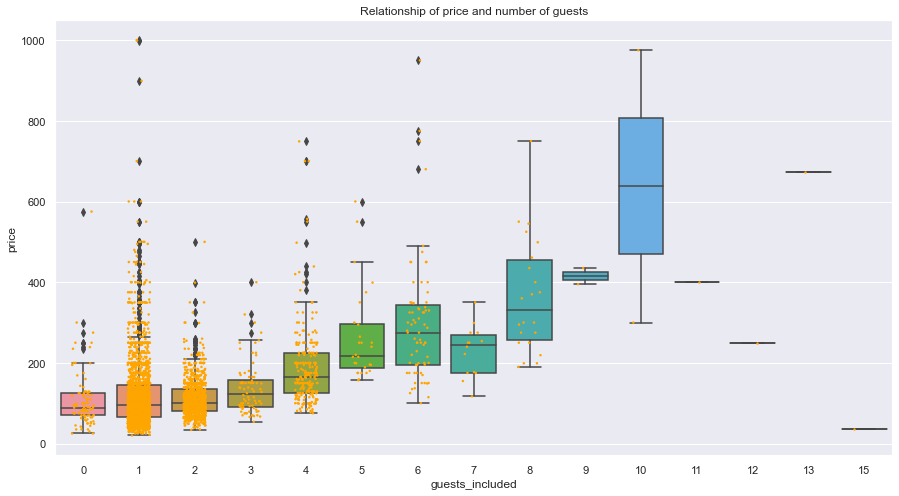

In [901]:
sns.boxplot(x=listings_add_booking["guests_included"], y=listings_add_booking["price"] )
sns.stripplot(x=listings_add_booking["guests_included"], y=listings_add_booking["price"], color="orange", jitter=0.2, size=2.5)
plt.title('Relationship of price and number of guests')

Text(0.5, 1.0, 'Relationship of book rate (30d) and flexibility of cancellation policy')

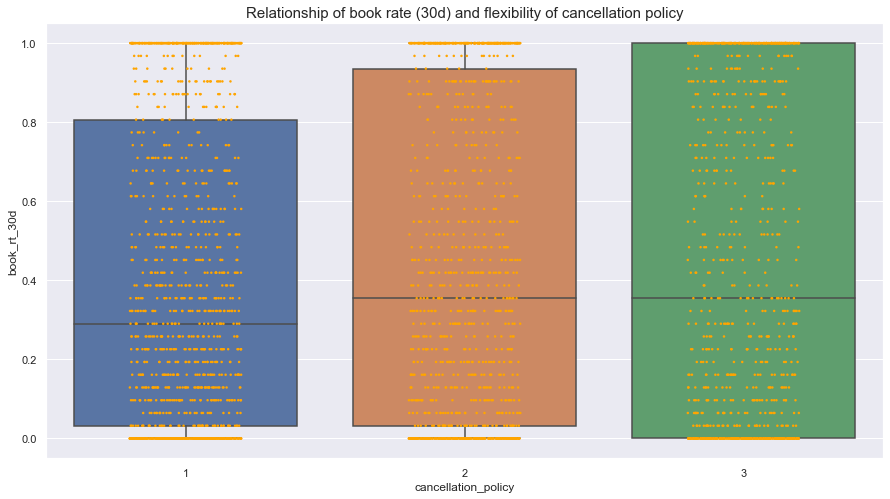

In [56]:
sns.boxplot(x=listings_add_booking["cancellation_policy"], y=listings_add_booking["book_rt_30d"] )
sns.stripplot(x=listings_add_booking["cancellation_policy"], y=listings_add_booking["book_rt_30d"], color="orange", jitter=0.2, size=2.5)
plt.title('Relationship of book rate (30d) and flexibility of cancellation policy',fontdict = {'fontsize' : 15})

Text(0.5, 1.0, 'Relationship of price and flexibility of cancellation policy')

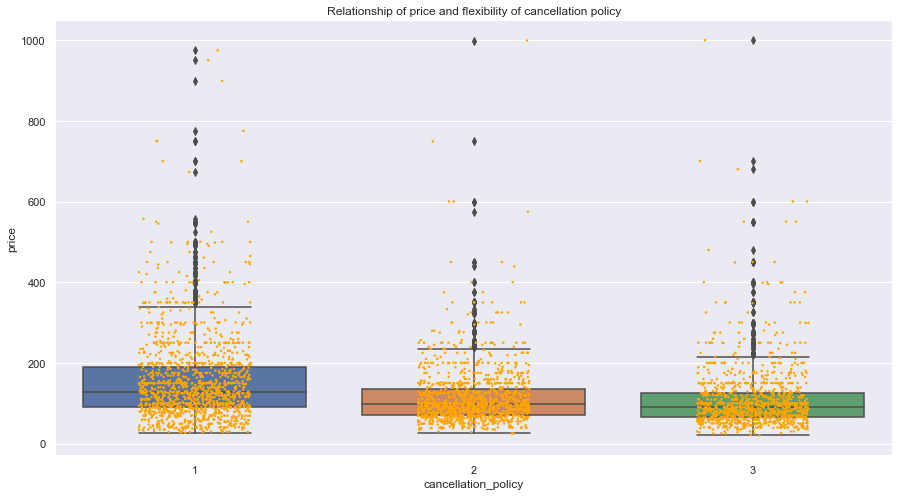

In [903]:
sns.boxplot(x=listings_add_booking["cancellation_policy"], y=listings_add_booking["price"] )
sns.stripplot(x=listings_add_booking["cancellation_policy"], y=listings_add_booking["price"], color="orange", jitter=0.2, size=2.5)
plt.title('Relationship of price and flexibility of cancellation policy')

* other exploration of relationship visualizaions

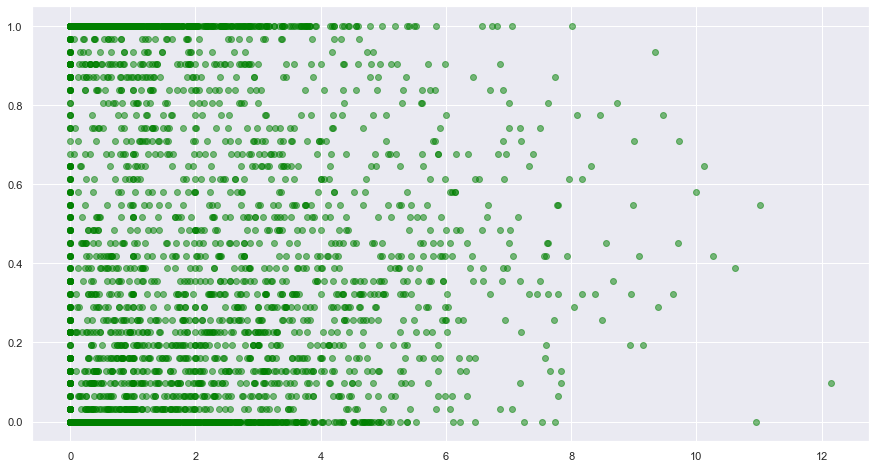

In [904]:
plt.scatter(listings_add_booking['reviews_per_month'],listings_add_booking['book_rt_30d'],color='green',marker='o',alpha=0.5)

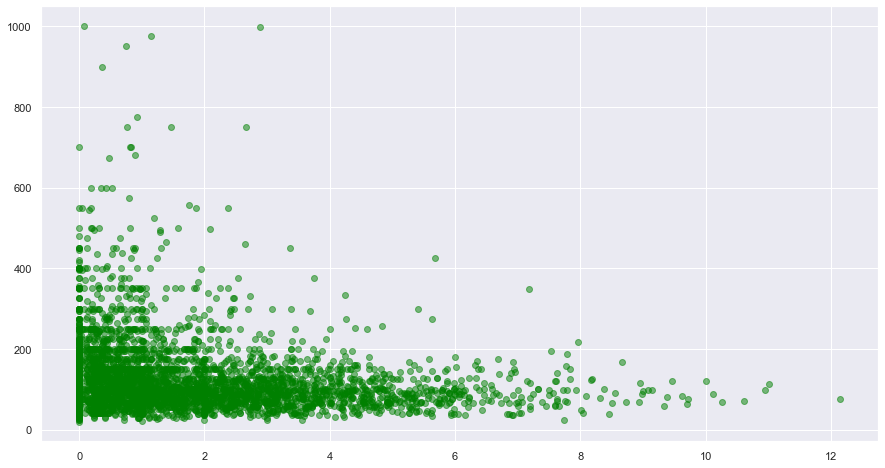

In [905]:
plt.scatter(listings_add_booking['reviews_per_month'],listings_add_booking['price'],color='green',marker='o',alpha=0.5)

Text(0.5, 1.0, 'Relationship of book rate (30d) and number of bathrooms')

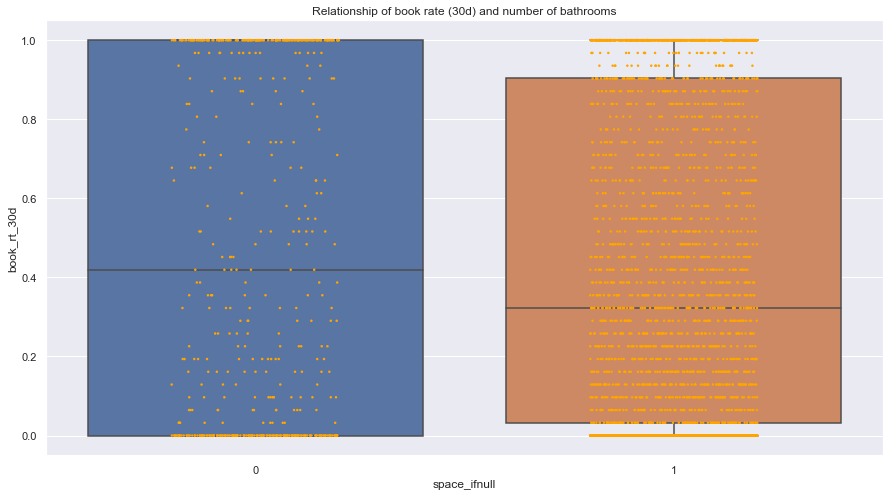

In [906]:
sns.boxplot(x=listings_add_booking["space_ifnull"], y=listings_add_booking["book_rt_30d"] )
sns.stripplot(x=listings_add_booking["space_ifnull"], y=listings_add_booking["book_rt_30d"], color="orange", jitter=0.2, size=2.5)
plt.title('Relationship of book rate (30d) and number of bathrooms')

Text(0.5, 1.0, 'Relationship of price and listing location exact')

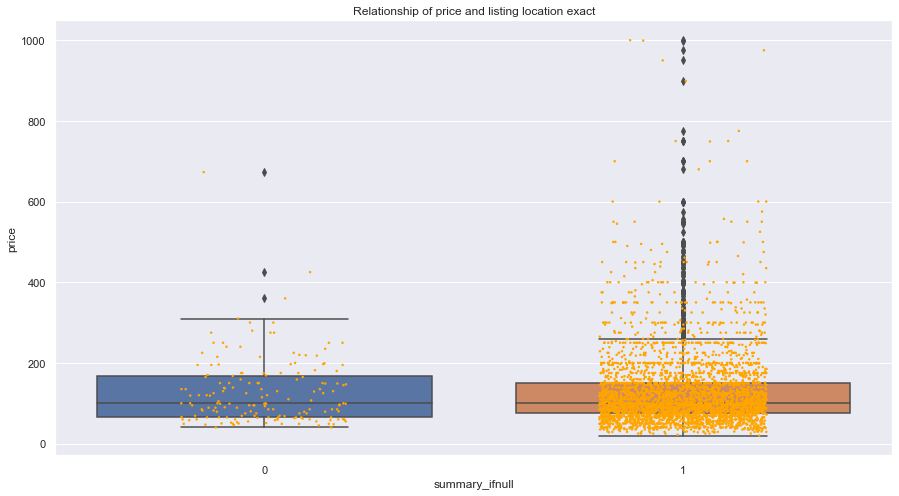

In [907]:
sns.boxplot(x=listings_add_booking["summary_ifnull"], y=listings_add_booking["price"] )
sns.stripplot(x=listings_add_booking["summary_ifnull"], y=listings_add_booking["price"], color="orange", jitter=0.2, size=2.5)
plt.title('Relationship of price and listing location exact')

### 3. predict listing price

#### 3.1 Data preparation

In [924]:
#neigborhood use number of listing replace
list_gp_neigh.rename({'id':'listing_cnt'},axis=1,inplace=True)
listings_add_booking2 = pd.merge(listings_add_booking,list_gp_neigh[['neighbourhood_group_cleansed','listing_cnt']],\
                        on=['neighbourhood_group_cleansed'],how='left')
listings_add_booking2.rename({'listing_cnt':'neighborhood_listing_cnt'},axis=1,inplace=True)
del listings_add_booking2['neighbourhood_group_cleansed']

In [925]:
col_to_dummy = ['property_type','room_type']
for col in col_to_dummy:
    dummy_df = pd.get_dummies(listings_add_booking2[col],prefix=col,prefix_sep='_')
    listings_add_booking2 = pd.concat([listings_add_booking2.drop(col,axis=1),dummy_df],axis=1)

#### 3.2 Multiple linearn regressio model/variable selection

In [939]:
price_prediction_cols = ['price','host_since', 'host_response_time', 'host_response_rate',
                    'host_is_superhost', 'host_listings_count', 'host_total_listings_count',
                    'host_identity_verified', 'is_location_exact', 'accommodates',
                    'bathrooms', 'bedrooms', 'beds', 'guests_included',
                    'extra_people', 'minimum_nights', 'maximum_nights', 'calendar_updated',
                    'availability_30', 'availability_60', 'availability_90',
                    'availability_365', 'number_of_reviews', 'first_review', 'last_review',
                    'review_scores_rating', 'review_scores_accuracy',
                    'review_scores_cleanliness', 'review_scores_checkin',
                    'review_scores_communication', 'review_scores_location',
                    'review_scores_value', 'instant_bookable', 'cancellation_policy',
                    'require_guest_profile_picture', 'require_guest_phone_verification',
                    'calculated_host_listings_count', 'reviews_per_month',
                    'host_listing_same_neighbor', 'host_verifications_cnt',
                    'host_verifications_basic', 'summary_ifnull', 'space_ifnull',
                    'neighborhood_overview_ifnull', 'notes_ifnull', 'transit_ifnull',
                    'thumbnail_url_ifnull', 'host_about_ifnull', 'first_review_ifnull',
                    'neighborhood_listing_cnt',
                    'property_type_Apartment', 'property_type_House', 'property_type_Other',
                    'room_type_Entire home/apt', 'room_type_Private room',
                    'room_type_Shared room']
listings_price_prediction = listings_add_booking2[price_prediction_cols]

In [940]:
#tt split
from sklearn.model_selection import train_test_split
price_pred_df_train, price_pred_df_test = train_test_split(listings_price_prediction,train_size = 0.6, test_size = 0.4, random_state=100)

In [941]:
#scale continuous variables (specify these columns)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
num_vars = ['host_since','host_response_time','host_response_rate',
            'host_is_superhost', 'host_listings_count', 'host_total_listings_count',
            'accommodates','bathrooms', 'bedrooms', 'beds', 'guests_included',
            'extra_people', 'minimum_nights', 'maximum_nights', 'calendar_updated',
            'availability_30', 'availability_60', 'availability_90',
            'availability_365', 'number_of_reviews', 'first_review', 'last_review',
            'review_scores_rating', 'review_scores_accuracy',
            'review_scores_cleanliness', 'review_scores_checkin',
            'review_scores_communication', 'review_scores_location',
            'review_scores_value', 'cancellation_policy','calculated_host_listings_count']
price_pred_df_train[num_vars] = scaler.fit_transform(price_pred_df_train[num_vars])
price_pred_df_test[num_vars] = scaler.transform(price_pred_df_test[num_vars])
y_train = price_pred_df_train.pop('price')
X_train = price_pred_df_train
y_test = price_pred_df_test.pop('price')
X_test = price_pred_df_test

In [961]:
#use recursive feature elimination to select predictive indepent variables,use test set to select number of variables to keep
from sklearn.feature_selection import RFE 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [986]:
def pred_x_num_select(x_num,X_train,y_train,X_test,y_test):
    lm = LinearRegression()
    lm.fit(X_train, y_train)

    rfe = RFE(lm, x_num) # running RFE
    rfe = rfe.fit(X_train, y_train)

    rfe_result = list(zip(X_train.columns,rfe.support_,rfe.ranking_))
    var_select = []
    for i in rfe_result:
        if i[1] == True:
            var_select.append(i[0])

    X_train_new = X_train[var_select]
    lm.fit(X_train_new,y_train)
    y_test_preds = lm.predict(X_test[var_select])
    r2 = r2_score(y_test,y_test_preds)
    r2_adj = 1-(1-r2)*(1-r2)*(len(y_test)-1)/(len(y_test)-1-x_num)
    return r2_adj


In [988]:
test_score = {}
for i in range(1,56):
   test_score[i] = pred_x_num_select(i,X_train,y_train,X_test,y_test)

Text(0, 0.5, 'adj r^2')

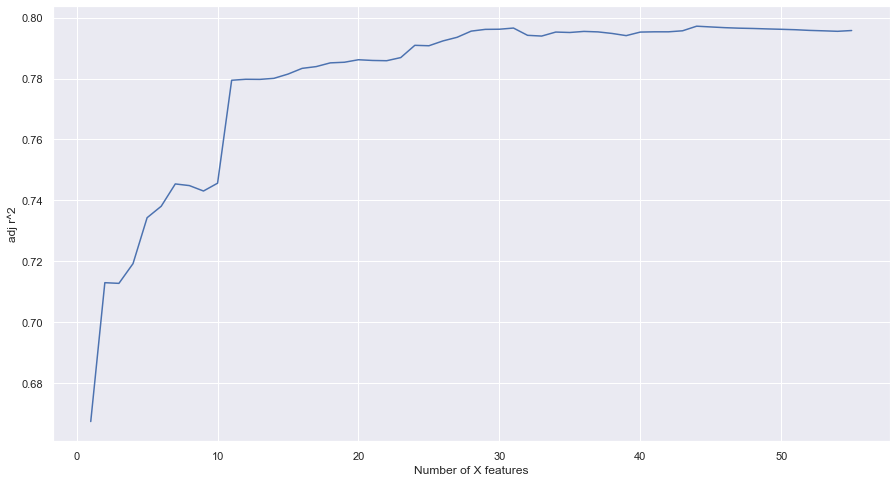

In [989]:
s = pd.Series(test_score)
s.plot()
plt.xlabel('Number of X features')
plt.ylabel('adj r^2')

In [1025]:
#final model: x_num = 30
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 30) # running RFE
rfe = rfe.fit(X_train, y_train)

rfe_result = list(zip(X_train.columns,rfe.support_,rfe.ranking_))
var_select = []
for i in rfe_result:
    if i[1] == True:
        var_select.append(i[0])

In [1026]:
import statsmodels.api as sm
X_train_lm = sm.add_constant(X_train[var_select])
lr_1 = sm.OLS(y_train, X_train_lm).fit()
lr_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.559
Method:                 Least Squares   F-statistic:                     100.1
Date:                Tue, 12 Jul 2022   Prob (F-statistic):               0.00
Time:                        09:26:36   Log-Likelihood:                -12377.
No. Observations:                2268   AIC:                         2.481e+04
Df Residuals:                    2238   BIC:                         2.499e+04
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                           -68.2426     49.356     -1.383      0.167    -165.031      28.546
host_response_time                7.7191      7.905      0.976      0.329      -7.783      23.221
host_response_rate              -18.8810      7.653     -2.467      0.014     -33.889      -3.874
host_is_superhost                12.2346      3.198      3.826      0.000       5.964      18.505
host_listings_count              11.8907      8.490      1.401      0.161      -4.759      28.540
host_total_listings_count        11.8907      8.490      1.401      0.161      -4.759      28.540
accommodates                    118.2063     22.013      5.370      0.000      75.038     161.374
bathrooms                       218.1447     21.515     10.139      0.000     175.953     260.337
bedrooms                        192.7266     17.532     10.993      0.000     158.345     227.108
beds                             19.3389     31.079      0.622      0.534     -41.608      80.286
guests_included                  40.8949     18.372      2.226      0.026       4.868      76.922
extra_people                     25.2998     16.546      1.529      0.126      -7.147      57.747
calendar_updated                 47.2738     17.919      2.638      0.008      12.133      82.414
availability_90                  11.6216      3.388      3.431      0.001       4.978      18.265
number_of_reviews               -16.2231     19.525     -0.831      0.406     -54.511      22.065
first_review                    -22.7874     17.698     -1.288      0.198     -57.495      11.920
last_review                     107.7071     52.226      2.062      0.039       5.290     210.124
review_scores_rating             17.0677     25.206      0.677      0.498     -32.362      66.498
review_scores_accuracy           31.7161     21.884      1.449      0.147     -11.199      74.631
review_scores_cleanliness        37.0985     20.935      1.772      0.077      -3.956      78.152
review_scores_checkin           -28.1158     24.456     -1.150      0.250     -76.075      19.843
review_scores_communication     -49.3975     28.398     -1.739      0.082    -105.087       6.292
review_scores_location           83.0396     21.126      3.931      0.000      41.611     124.468
review_scores_value             -75.5324     23.991     -3.148      0.002    -122.579     -28.486
require_guest_profile_picture     8.2728      4.542      1.822      0.069      -0.633      17.179
space_ifnull                     -5.5648      3.604     -1.544      0.123     -12.633       1.503
thumbnail_url_ifnull             -6.1153      4.419     -1.384      0.167     -14.781       2.551
first_review_ifnull              65.7563     48.360      1.360      0.174     -29.078     160.590
property_type_Other              10.9198     

In [1068]:
#var_select.remove('host_response_time')
#var_select.remove('beds')
#var_select.remove('review_scores_rating')
#var_select.remove('number_of_reviews')
#var_select.remove('review_scores_checkin')
#var_select.remove('review_scores_accuracy')
#var_select.remove('host_listings_count')
#var_select.remove('host_total_listings_count')
#var_select.remove('extra_people')
#var_select.remove('thumbnail_url_ifnull')
#var_select.remove('space_ifnull')
#var_select.remove('first_review_ifnull')
#var_select.remove('review_scores_communication')
#var_select.remove('review_scores_value')
#var_select.remove('review_scores_cleanliness')
#var_select.remove('first_review')
var_select.remove('require_guest_profile_picture')

In [1069]:
X_train_lm = sm.add_constant(X_train[var_select])
lr_1 = sm.OLS(y_train, X_train_lm).fit()
lr_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     216.5
Date:                Tue, 12 Jul 2022   Prob (F-statistic):               0.00
Time:                        09:35:56   Log-Likelihood:                -12401.
No. Observations:                2268   AIC:                         2.483e+04
Df Residuals:                    2254   BIC:                         2.491e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                       -17.9592     13.034     -1.378      0.168     -43.519       7.600
host_response_rate          -26.4207      4.003     -6.599      0.000     -34.272     -18.570
host_is_superhost             9.8303      3.082      3.190      0.001       3.787      15.874
accommodates                129.4950     17.128      7.561      0.000      95.907     163.083
bathrooms                   222.2271     21.555     10.310      0.000     179.958     264.496
bedrooms                    195.3366     17.034     11.467      0.000     161.933     228.741
guests_included              39.2793     16.539      2.375      0.018       6.846      71.712
calendar_updated             53.8594     17.367      3.101      0.002      19.802      87.917
availability_90              12.2785      3.352      3.663      0.000       5.705      18.852
last_review                  32.1606     12.211      2.634      0.009       8.215      56.106
review_scores_location       26.1453     12.125      2.156      0.031       2.368      49.922
property_type_Other          10.2147      4.109      2.486      0.013       2.156      18.273
room_type_Entire home/apt    46.7186      3.097     15.086      0.000      40.646      52.791
room_type_Shared room       -24.8986      7.065     -3.524      0.000     -38.753     -11.044
==============================================================================
Omnibus:                     2191.159   Durbin-Watson:                   2.079
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           238369.710
Skew:                           4.278   Prob(JB):                         0.00
Kurtosis:                      52.490   Cond. No.                         35.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1070]:
# Checking for the VIF values of the variables. 
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Creating a dataframe that will contain the names of all the feature variables and their VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[var_select].columns
vif['VIF'] = [variance_inflation_factor(X_train[var_select].values, i) for i in range(X_train[var_select].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
9,review_scores_location,13.94
4,bedrooms,9.78
3,bathrooms,9.43
2,accommodates,8.15
0,host_response_rate,8.03
11,room_type_Entire home/apt,4.25
7,availability_90,4.16
5,guests_included,3.70
8,last_review,3.47
6,calendar_updated,1.59


#### 3.3 Final model output

In [1075]:
#make final prediction
X_train_new = X_train[var_select]
lm.fit(X_train_new,y_train)
y_test_preds = lm.predict(X_test[var_select])
r2 = r2_score(y_test,y_test_preds)
r2_adj = 1-(1-r2)*(1-r2)*(len(y_test)-1)/(len(y_test)-1-13)
print('r2_adj',r2_adj)
print('r2',r2)

r2_adj 0.7875593536311659
r2 0.5410741916264251
